In [22]:
from game_utils.ContinuousPokerVariants.LCP import LCP, LCP_utils
from game_utils.ContinuousPokerVariants.LCP_symbolic import LCP_symbolic
from game_utils.ContinuousPokerVariants.NLCP import NLCP
from game_utils.ContinuousPokerVariants.FBCP import FBCP
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import importlib

# Set larger font sizes for plots
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})


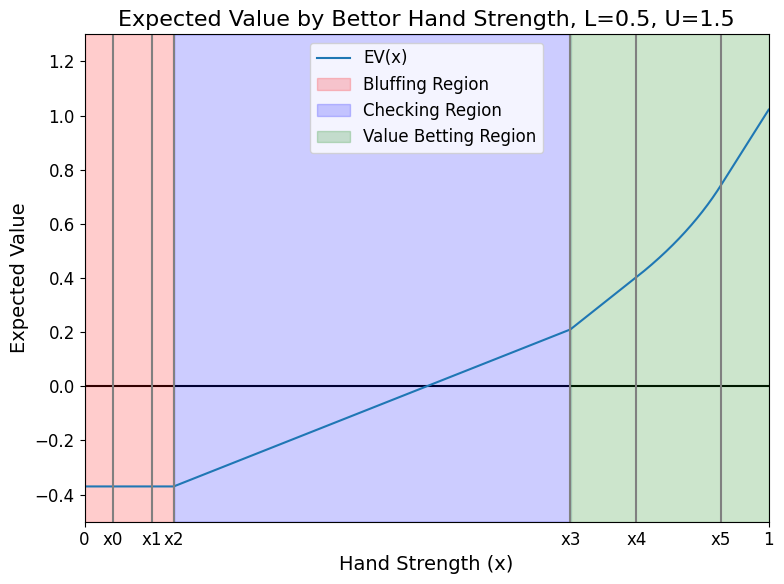

In [23]:
# a line graph of the EV(x) over a range of x values for fixed L and U
game_params = {"L": 0.5, "U": 1.5}
fig, ax = plt.subplots(figsize=(8, 6))
ylims = [-0.5, 1.3]
xlims = [0, 1]

# EV(x) line graph
X = np.linspace(0, 1, 1001)
payoffs = []
for x in X:
    payoff = LCP.expected_payoff_x(x=x, **game_params)
    payoffs.append(payoff)
ax.plot(X, payoffs, label="EV(x)")
ax.set_title("Expected Value by Bettor Hand Strength, L=0.5, U=1.5")
ax.set_xlabel("Hand Strength (x)")
ax.set_ylabel("Expected Value")
ax.axhline(y=0, color='black', zorder=0)

# Get x values for vertical lines
x0 = LCP_utils.compute_x0(game_params)
x1 = LCP_utils.compute_x1(game_params)
x2 = LCP_utils.compute_x2(game_params)
x3 = LCP_utils.compute_x3(game_params)
x4 = LCP_utils.compute_x4(game_params)
x5 = LCP_utils.compute_x5(game_params)

# Plot vertical lines and add labels
x_values = [x0, x1, x2, x3, x4, x5]
x_labels = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']

for x, label in zip(x_values, x_labels):
    ax.vlines(x, ylims[0], ylims[1], color="grey")
    ax.text(x, ylims[0]-0.035, label, ha='center', va='top')

# Add shaded regions
ax.fill_between(X, ylims[0], ylims[1], where=(X >= 0) & (X <= x2), alpha=0.2, color='red', label='Bluffing Region')
ax.fill_between(X, ylims[0], ylims[1], where=(X >= x2) & (X <= x3), alpha=0.2, color='blue', label='Checking Region') 
ax.fill_between(X, ylims[0], ylims[1], where=(X >= x3) & (X <= 1), alpha=0.2, color='green', label='Value Betting Region')
ax.legend()

ax.set_xlim([0, 1])
ax.set_ylim([-0.5, 1.3])
ax.set_xticks([0, 1])
plt.tight_layout()
plt.show()


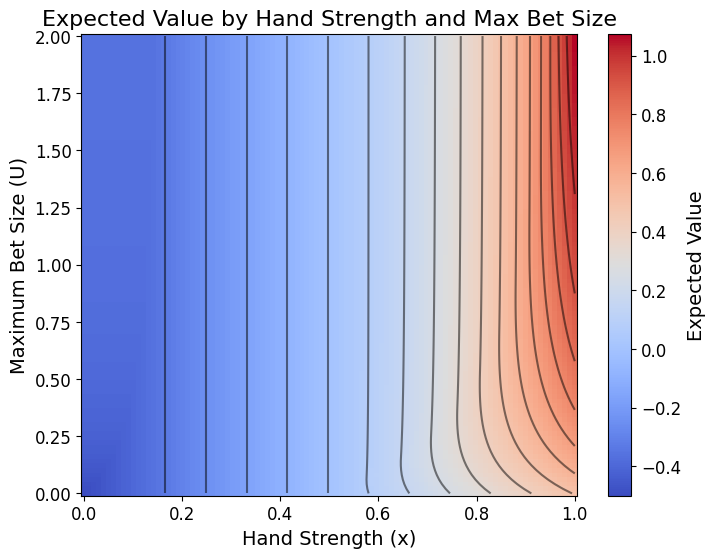

In [24]:
# Heatmap of EV(x) for x from 0 to 1, and U from 0 to 2
bth = LCP.bluff_threshold(**game_params)

# Create a grid of x values from 0 to 1 and U values from 0 to 2
x_vals = np.linspace(0, 1, 100)
U_vals = np.linspace(0, 2, 100)
X, U = np.meshgrid(x_vals, U_vals)

# Initialize array to store payoffs
payoffs = np.zeros_like(X)

# Compute payoff for each (x,U) pair
for i in range(len(U_vals)):
    for j in range(len(x_vals)):
        game_params = {"L": 0, "U": U_vals[i]}
        payoffs[i,j] = LCP.expected_payoff_x(x_vals[j], **game_params)

# Create figure and plot heatmap
plt.figure(figsize=(8,6))
plt.pcolormesh(X, U, payoffs, shading='auto', cmap='coolwarm')
plt.colorbar(label='Expected Value')

# # Add level curves on same axes
levels = np.linspace(np.min(payoffs), np.max(payoffs), 20)
plt.contour(X[:, x_vals>bth], U[:, x_vals>bth], payoffs[:, x_vals>bth], levels=levels, colors='black', linestyles='solid', alpha=0.5)

plt.xlabel('Hand Strength (x)')
plt.ylabel('Maximum Bet Size (U)')
plt.title('Expected Value by Hand Strength and Max Bet Size')
plt.show()


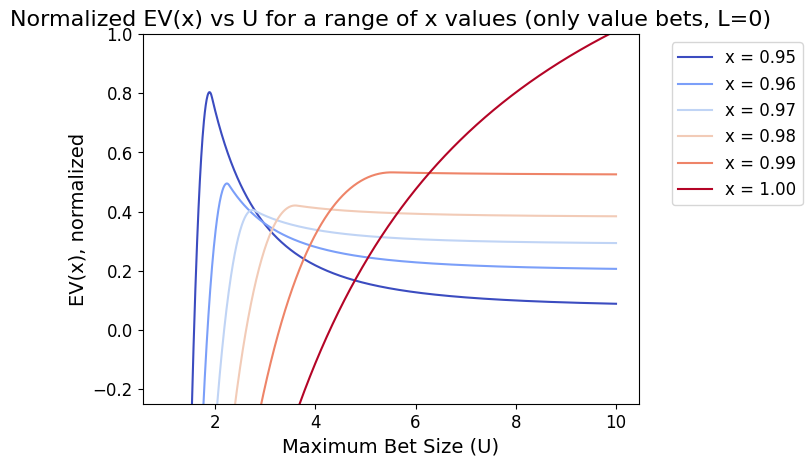

In [25]:
# EV(x) vs U for a range of x values (only value bets)
# vth = LCP.value_threshold(game_params)
U_vals = np.linspace(1, 10, 1000)

x_vals = np.linspace(0.95, 1, 6)

# Create a colormap from blue to red
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_vals)))

for i, x in enumerate(x_vals):
    payoffs = []
    for j, u in enumerate(U_vals):
        game_params = {"L": 0, "U": u}
        payoff = LCP.expected_payoff_x(x, U=u, L=0)
        payoffs.append(payoff)
    mean_payoff = np.mean(payoffs)
    STD = np.std(payoffs)
    normalized_payoffs = [(payoff - mean_payoff) / STD for payoff in payoffs]
    plt.plot(U_vals, normalized_payoffs, label=f"x = {x:.2f}", color=colors[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Normalized EV(x) vs U for a range of x values (only value bets, L=0)")
plt.xlabel('Maximum Bet Size (U)')
plt.ylabel("EV(x), normalized")
plt.ylim(-.25, 1)
plt.show()

# Notice the smaller x have decreasing EV(x) as U increases past a certain point.

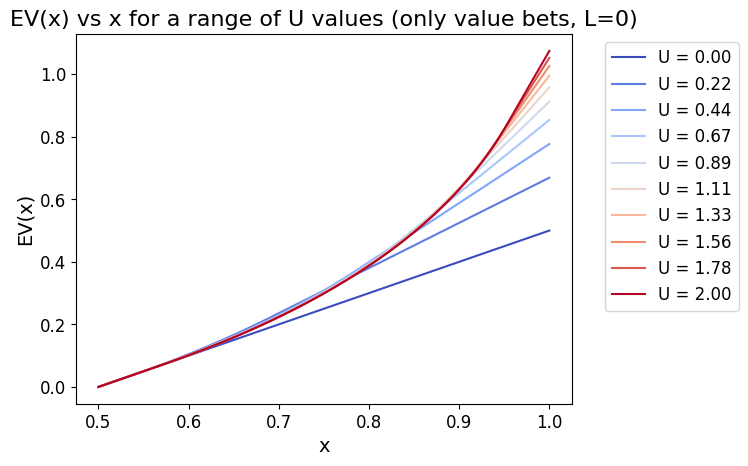

In [26]:
# EV(x) vs x for a range of U values
U_vals = np.linspace(0, 2, 10)

x_vals = np.linspace(0.5, 1, 100)

# Create a colormap from blue to red
colors = plt.cm.coolwarm(np.linspace(0, 1, len(U_vals)))

for i, U in enumerate(U_vals):
    payoffs = []
    for j, x in enumerate(x_vals):
        game_params = {"L": 0, "U": U}
        payoff = LCP.expected_payoff_x(x, U=U, L=0)
        payoffs.append(payoff)
    mean_payoff = np.mean(payoffs)
    STD = np.std(payoffs)
    # normalized_payoffs = [(payoff - mean_payoff) / STD for payoff in payoffs]
    plt.plot(x_vals, payoffs, label=f"U = {U:.2f}", color=colors[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("EV(x) vs x for a range of U values (only value bets, L=0)")
plt.xlabel('x')
plt.ylabel("EV(x)")
plt.show()

# Notice the smaller x have decreasing EV(x) as U increases past a certain point.

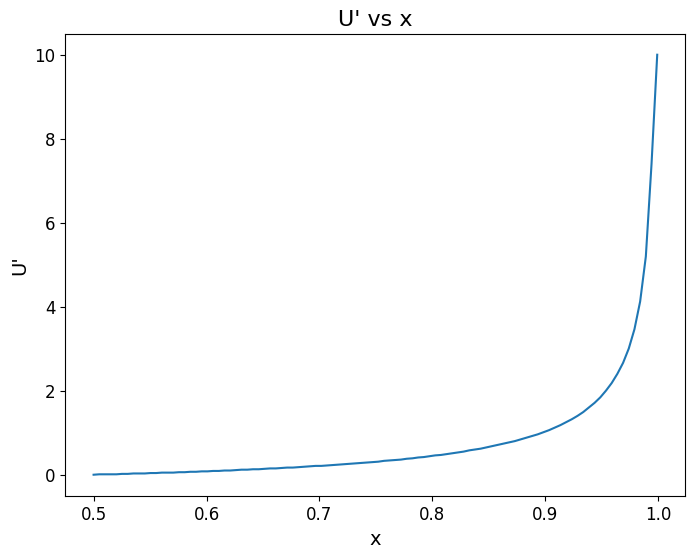

In [27]:
def decreasing_past_index(arr, index):
    return all(arr[i] < arr[index] for i in range(index+1, len(arr)))

def decreasing_before_index(arr, index):
    return all(arr[i] < arr[index] for i in range(index))

def increasing_past_index(arr, index):
    return all(arr[i] > arr[index] for i in range(index+1, len(arr)))

def increasing_before_index(arr, index):
    return all(arr[i] > arr[index] for i in range(index))

n=100
m=1000
x_vals = np.linspace(0.5, 0.999, n)
U_vals = np.linspace(0, 10, m)
EVs = np.zeros((n, m))
bet_sizes = np.zeros((n, m)) # bet size for x, U
call_thresholds = np.zeros((n, m)) # call threshold for s=v_inv(x), U
for i, x in enumerate(x_vals):
    for j, U in enumerate(U_vals):
        game_params = {"L": 0, "U": U}
        EVs[i, j] = LCP.expected_payoff_x(x, **game_params)
        x2 = LCP_utils.compute_x2(game_params)
        bet_sizes[i, j] = LCP_utils.inverse_v(x, x2)
        call_thresholds[i, j] = LCP.call_threshold(bet_sizes[i, j], **game_params)

# TO TEST HYPOTHESIS: find the x for which EV(x) has a local argmax U' (which is not the max U).
argmaxes = np.argmax(EVs, axis=1)
has_local_max = argmaxes < m-1 # t/f for each index

# ensure the bet size v_inv(x) is decreasing in U past U'.
bet_size_decreasing = np.array([decreasing_past_index(bet_sizes[i], argmaxes[i]) for i in range(n)])
# ensure the bet size v_inv(x) is increasing in U before U'.
bet_size_increasing = np.array([increasing_before_index(bet_sizes[i], argmaxes[i]) for i in range(n)])

# the call threshold c(v_inv(x)) is increasing in U ... always.
call_threshold_increasing = np.array([increasing_past_index(call_thresholds[i], 0) for i in range(n)])

# should hold for all x, U, since we picked the U' as the argmax of EV(x, U).
assert np.all(call_threshold_increasing)
assert np.all(bet_size_decreasing)

# now, plot the U' vs x.
U_primes = U_vals[argmaxes]
plt.figure(figsize=(8, 6))
plt.plot(x_vals, U_primes)
plt.xlabel("x")
plt.ylabel("U'")
plt.title("U' vs x")
plt.show()


# np.logical_and(has_local_max, bet_size_decreasing)

# also test the converse: find the x for which EV(x) is maximized by maximizing U.
# check that for all U such that x < v(U), the call threshold c(v_inv(x)) is increasing in U.


0.08181818181818182


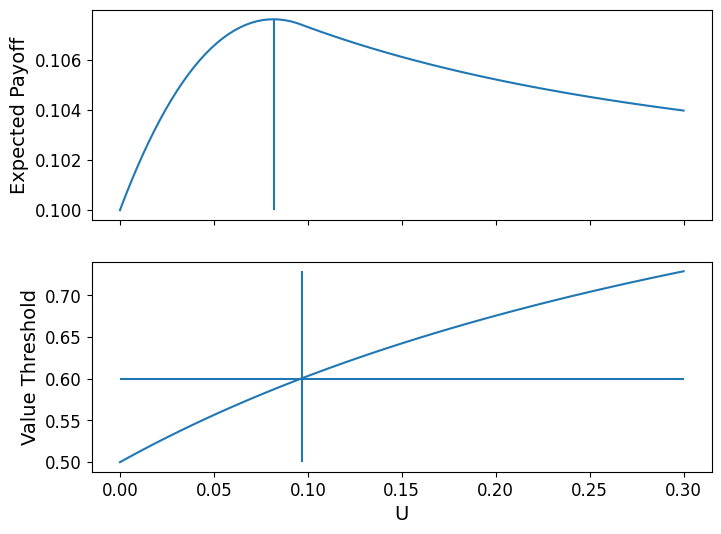

In [16]:
# plot EV(x) for a fixed x as a function of U

Ulims=(0, .3)
x = 0.6
U = np.linspace(Ulims[0], Ulims[1], 100)
payoffs = np.zeros_like(U)
vths = np.zeros_like(U)
for i, u in enumerate(U):
    game_params = {"L": 0, "U": u}
    payoffs[i] = LCP.expected_payoff_x(x, **game_params)
    vths[i] = LCP_utils.compute_x5(game_params)

max_i = np.argmax(payoffs)
print(U[max_i])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax1.plot(U, payoffs)
ax1.vlines([U[max_i]], min(payoffs), max(payoffs))
ax1.set_ylabel('Expected Payoff')

ax2.plot(U, vths)
ax2.hlines([x], Ulims[0], Ulims[1])
ax2.vlines([U[np.argmin(np.abs(x-vths))]], min(vths), max(vths))
ax2.set_xlabel('U')
ax2.set_ylabel('Value Threshold')

plt.show()


Rows:   0%|          | 0/1001 [00:00<?, ?it/s]

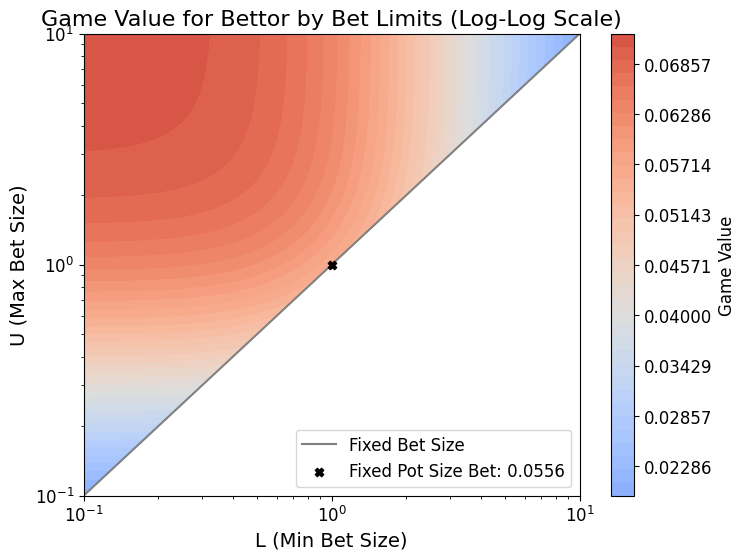

In [17]:
# EXPECTED PAYOFF OVER L, U GRID

def payoffs_over_grid(Ls, Us):
    L_grid, U_grid = np.meshgrid(Ls, Us)

    # Initialize an array to store expected payoffs
    payoff_grid = np.full_like(L_grid, np.nan, dtype=np.float64)

    # Compute expected payoff for each pair (L, U) where L < U
    for i in tqdm(range(L_grid.shape[0]), desc="Rows"):
        for j in range(L_grid.shape[1]):
            L = L_grid[i, j]
            U = U_grid[i, j]
            if L <= U:
                params = {"L": L, "U": U}
                LCP_utils.clear_cache()
                avg_payoff = LCP.expected_payoff_symbolic(**params)
                payoff_grid[i, j] = avg_payoff
    return payoff_grid

def plot_payoff_heatmap(Ls, Us, payoff_grid, cap, log_scale=False, debug=False):

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(Ls, Us, payoff_grid, levels=50, cmap="coolwarm", vmax=0.08, vmin=0)

    # Add a diagonal line from (0, 0) to (cap, cap)
    plt.plot([np.min(Ls), np.max(Ls)], [np.min(Us), np.max(Us)], color="grey", linestyle="-", label="Fixed Bet Size")
    
    # add another offset diagonal to test some things
    # plt.plot([np.min(Ls), np.max(Ls)], [5*np.min(Us), 5*np.max(Us)], color="grey", linestyle="-", label="Offset diagonal")

    # Add a point at (1,1) labeled with the value there, ensuring it is on the line
    value_at_point = payoff_grid[np.argmin(np.abs(Ls - 1)), np.argmin(np.abs(Us - 1))]
    plt.scatter(1, 1, marker="X", color="black", label=f"Fixed Pot Size Bet: {value_at_point:.4f}", zorder=5)
    plt.legend(loc="lower right")  # Move the legend to the bottom right

    # Add a color bar with the same colormap
    cbar = plt.colorbar(contour, ticks=np.linspace(0, 0.08, 15))
    cbar.set_label("Game Value", fontsize=12)

    if debug:
        # pick a random point, call it log(L1), log(U1)
        # find the point reflected across the diagonal: -log(U1), -log(L1)
        # find the payoff at both points and print them
        # also plot both points
        logL1 = np.random.uniform(-np.log10(cap), np.log10(cap))
        logU1 = np.random.uniform(-np.log10(cap), np.log10(cap))
        L1 = 10**logL1
        U1 = 10**logU1
        L2 = 10**(-logU1)
        U2 = 10**(-logL1)
        payoff1 = LCP.expected_payoff_symbolic(L=L1, U=U1)
        payoff2 = LCP.expected_payoff_symbolic(L=L2, U=U2)
        print(f"Payoff at ({L1:.4f}, {U1:.4f}): {payoff1:.4f}")
        print(f"Payoff at ({L2:.4f}, {U2:.4f}): {payoff2:.4f}")
        plt.scatter(L1, U1, marker="o", color="blue", label=f"Point 1: {payoff1:.4f}", zorder=5)
        plt.scatter(L2, U2, marker="o", color="red", label=f"Point 2: {payoff2:.4f}", zorder=5)

    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim([np.min(Ls), np.max(Ls)])
        plt.ylim([np.min(Us), np.max(Us)])
        plt.title("Game Value for Bettor by Bet Limits (Log-Log Scale)")
    else:
        plt.xlim([0, cap])
        plt.ylim([0, cap])
        plt.title("Game Value for Bettor by Bet Limits")
    plt.xlabel("L (Min Bet Size)")
    plt.ylabel("U (Max Bet Size)")
    plt.show()

grid_size = 1001

# cap = 2
# Ls = np.linspace(0, cap, grid_size)
# Us = np.linspace(0, cap, grid_size)
# plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap)

# cap = 10
# Ls = np.linspace(0, cap, grid_size)
# Us = np.linspace(0, cap, grid_size)
# plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap)

cap = 10
Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap, log_scale=True)

# cap = 10000
# Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
# Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
# plot_payoff_heatmap(Ls, Us, payoffs_over_grid(Ls, Us), cap, log_scale=True)




Computing game values:   0%|          | 0/1001 [00:00<?, ?it/s]

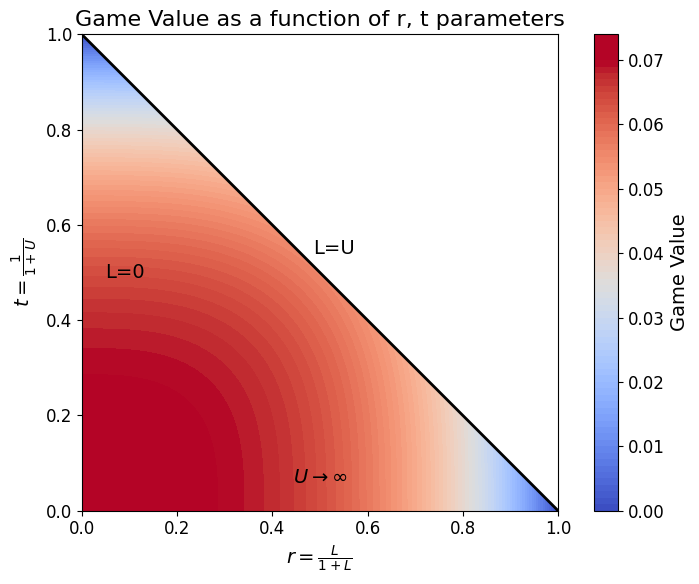

In [18]:
# EXPECTED PAYOFF OVER r, t GRID

def values_over_grid(rs, ts):
    """Compute game values over a grid of r, t parameters.

    Parameters:
    - rs: array of r values (r = L/(1+L))
    - ts: array of t values (t = 1/(1+U))

    Returns:
    - value_grid: 2D array of game values
    """
    r_grid, t_grid = np.meshgrid(rs, ts)
    value_grid = np.full_like(r_grid, np.nan, dtype=np.float64)

    # Compute expected payoff for each pair (r, t) where r + t <= 1
    for i in tqdm(range(r_grid.shape[0]), desc="Computing game values"):
        for j in range(r_grid.shape[1]):
            r = r_grid[i, j]
            t = t_grid[i, j]
            if r + t <= 1:
                value = LCP_symbolic.game_value_symbolic(r=r, t=t)
                value_grid[i, j] = value
    return value_grid


def plot_value_heatmap(rs, ts, value_grid, save_path=None):
    """Plot a heatmap of game values over r, t parameters.

    Parameters:
    - rs: array of r values
    - ts: array of t values
    - value_grid: 2D array of game values
    - save_path: optional path to save the figure
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create contour plot with cleaner color scale
    levels = np.arange(0, 0.075, 0.001)
    contour = ax.contourf(rs, ts, value_grid, levels=levels, cmap="coolwarm", vmin=0, vmax=0.07)

    # Add symmetry diagonal from (0, 1) to (1, 0)
    ax.plot([0, 1], [1, 0], color="black", linestyle="-", linewidth=2, zorder=5)

    # Add colorbar with round number ticks
    cbar_ticks = np.arange(0, 0.08, 0.01)
    cbar = plt.colorbar(contour, ax=ax, ticks=cbar_ticks)
    cbar.set_label("Game Value", fontsize=14)

    # Labels with definitions
    ax.set_xlabel(r"$r = \frac{L}{1+L}$", fontsize=14)
    ax.set_ylabel(r"$t = \frac{1}{1+U}$", fontsize=14)
    ax.set_title("Game Value as a function of r, t parameters", fontsize=16)
    ax.set_aspect(1)

    # Set axis limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # Add text labels on the plot
    # Label on diagonal (just above the diagonal line)
    ax.text(0.53, 0.53, "L=U", fontsize=14, ha='center', va='bottom', color='black')    
    # Label on bottom edge (U -> infinity)
    ax.text(0.5, 0.05, r"$U \to \infty$", fontsize=14, ha='center', va='bottom',
            color='black')
    # Label on left edge (L=0)
    ax.text(0.05, 0.5, "L=0", fontsize=14, ha='left', va='center',
            color='black')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


# Generate the plot
grid_size = 1001
rs = np.linspace(0, 1, grid_size)
ts = np.linspace(0, 1, grid_size)
value_grid = values_over_grid(rs, ts)
plot_value_heatmap(rs, ts, value_grid)


Computing (L,U) grid:   0%|          | 0/501 [00:00<?, ?it/s]

Computing (r,t) grid:   0%|          | 0/501 [00:00<?, ?it/s]

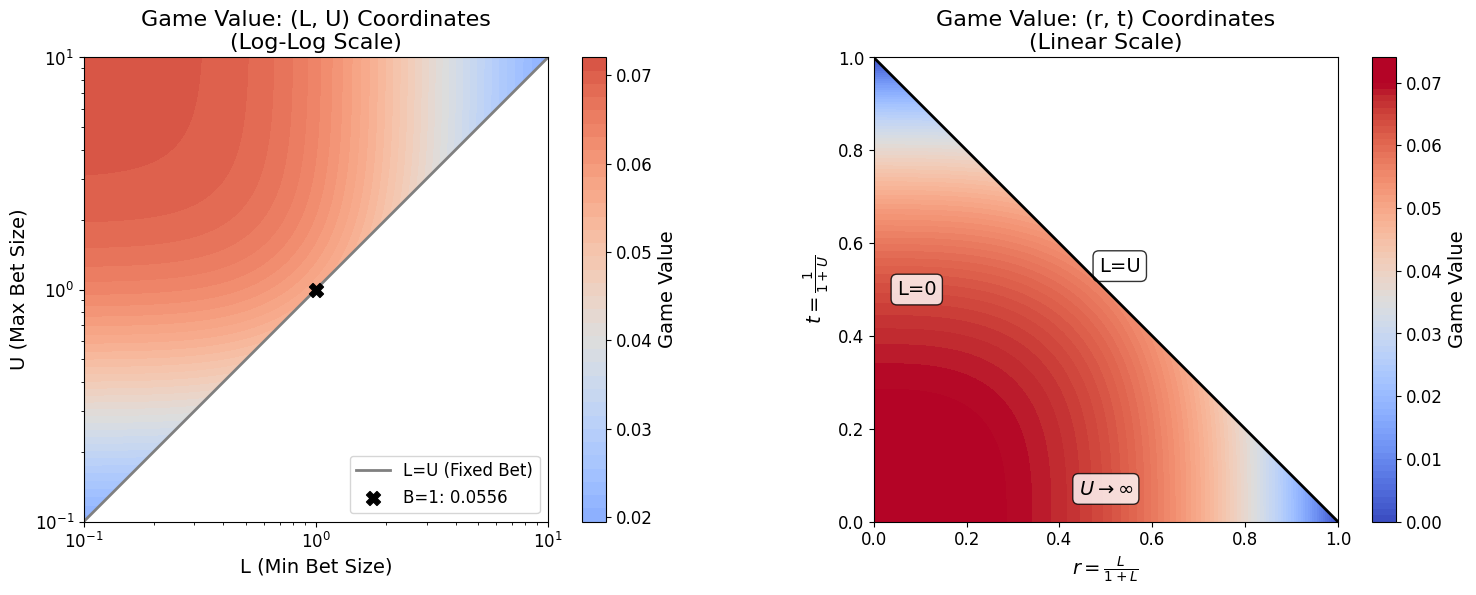

In [28]:
# COMBINED PLOT: Game value over both (L,U) and (r,t) coordinates side-by-side

def plot_combined_game_value(grid_size=1001, save_path=None):
    """
    Create a combined figure with two subplots showing game value in both
    (L,U) and (r,t) coordinate systems.
    
    Parameters:
    - grid_size: resolution of the grid (default 1001)
    - save_path: optional path to save the figure
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ============== LEFT PLOT: (L,U) coordinates (log-log scale) ==============
    cap = 10
    Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
    Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
    
    # Compute payoff grid for (L,U)
    L_grid, U_grid = np.meshgrid(Ls, Us)
    payoff_grid = np.full_like(L_grid, np.nan, dtype=np.float64)
    
    for i in tqdm(range(L_grid.shape[0]), desc="Computing (L,U) grid"):
        for j in range(L_grid.shape[1]):
            L = L_grid[i, j]
            U = U_grid[i, j]
            if L <= U:
                params = {"L": L, "U": U}
                LCP_utils.clear_cache()
                avg_payoff = LCP.expected_payoff_symbolic(**params)
                payoff_grid[i, j] = avg_payoff
    
    # Plot (L,U) heatmap
    contour1 = ax1.contourf(Ls, Us, payoff_grid, levels=50, cmap="coolwarm", vmax=0.08, vmin=0)
    ax1.plot([np.min(Ls), np.max(Ls)], [np.min(Us), np.max(Us)], 
             color="grey", linestyle="-", linewidth=2, label="L=U (Fixed Bet)")
    
    # Add point at (1,1)
    value_at_point = payoff_grid[np.argmin(np.abs(Ls - 1)), np.argmin(np.abs(Us - 1))]
    ax1.scatter(1, 1, marker="X", color="black", s=100,
                label=f"B=1: {value_at_point:.4f}", zorder=5)
    
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlim([np.min(Ls), np.max(Ls)])
    ax1.set_ylim([np.min(Us), np.max(Us)])
    ax1.set_xlabel("L (Min Bet Size)", fontsize=14)
    ax1.set_ylabel("U (Max Bet Size)", fontsize=14)
    ax1.set_title("Game Value: (L, U) Coordinates\n(Log-Log Scale)", fontsize=16)
    ax1.legend(loc="lower right")
    ax1.set_aspect('equal')
    
    # Add colorbar for left plot
    cbar1 = plt.colorbar(contour1, ax=ax1, ticks=np.linspace(0, 0.08, 9))
    cbar1.set_label("Game Value", fontsize=14)
    
    # ============== RIGHT PLOT: (r,t) coordinates ==============
    rs = np.linspace(0, 1, grid_size)
    ts = np.linspace(0, 1, grid_size)
    
    # Compute value grid for (r,t)
    r_grid, t_grid = np.meshgrid(rs, ts)
    value_grid = np.full_like(r_grid, np.nan, dtype=np.float64)
    
    for i in tqdm(range(r_grid.shape[0]), desc="Computing (r,t) grid"):
        for j in range(r_grid.shape[1]):
            r = r_grid[i, j]
            t = t_grid[i, j]
            if r + t <= 1:
                value = LCP_symbolic.game_value_symbolic(r=r, t=t)
                value_grid[i, j] = value
    
    # Plot (r,t) heatmap
    levels = np.arange(0, 0.075, 0.001)
    contour2 = ax2.contourf(rs, ts, value_grid, levels=levels, cmap="coolwarm", vmin=0, vmax=0.07)
    
    # Add symmetry diagonal from (0, 1) to (1, 0)
    ax2.plot([0, 1], [1, 0], color="black", linestyle="-", linewidth=2, zorder=5)
    
    ax2.set_xlabel(r"$r = \frac{L}{1+L}$", fontsize=14)
    ax2.set_ylabel(r"$t = \frac{1}{1+U}$", fontsize=14)
    ax2.set_title("Game Value: (r, t) Coordinates\n(Linear Scale)", fontsize=16)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_aspect('equal')
    
    # Add text labels on the (r,t) plot
    ax2.text(0.53, 0.53, "L=U", fontsize=14, ha='center', va='bottom', 
             color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax2.text(0.5, 0.05, r"$U \to \infty$", fontsize=14, ha='center', va='bottom',
             color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax2.text(0.05, 0.5, "L=0", fontsize=14, ha='left', va='center',
             color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add colorbar for right plot
    cbar_ticks = np.arange(0, 0.08, 0.01)
    cbar2 = plt.colorbar(contour2, ax=ax2, ticks=cbar_ticks)
    cbar2.set_label("Game Value", fontsize=14)
    
    plt.tight_layout()

    
    plt.show()

# Generate the combined plot (this will take a while to compute both grids)
# Uncomment the line below to run:
plot_combined_game_value(grid_size=501)

Computing (L,U) grid:   0%|          | 0/501 [00:00<?, ?it/s]

Computing (r,t) grid:   0%|          | 0/501 [00:00<?, ?it/s]

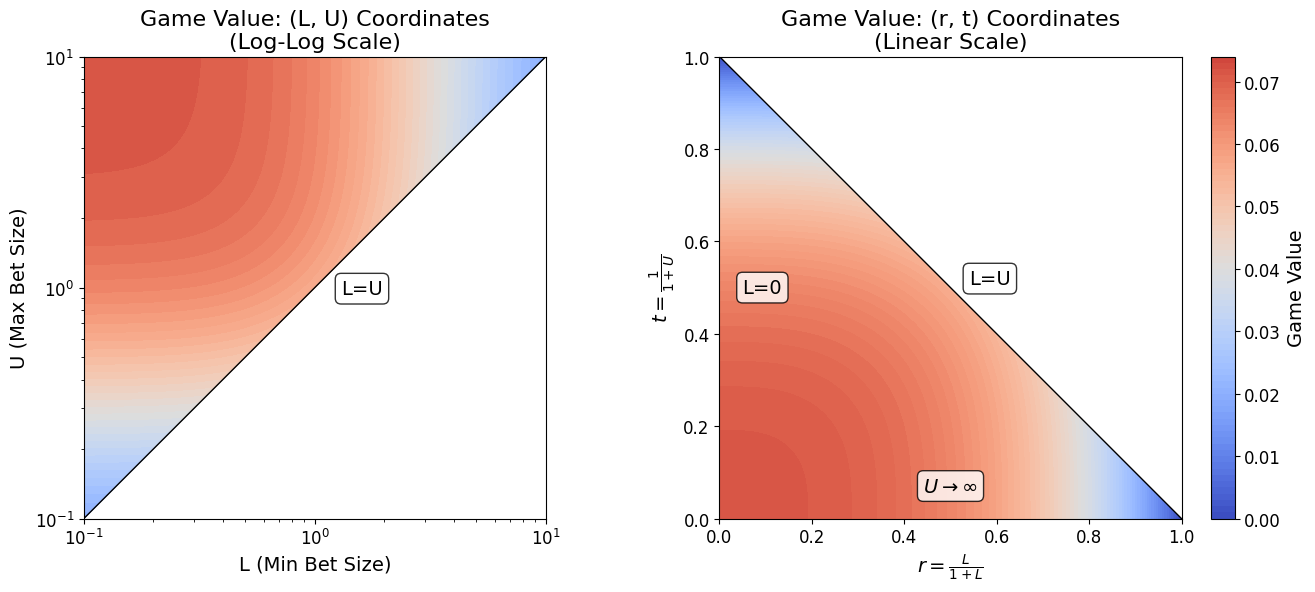

In [48]:
# COMBINED PLOT: Game value over both (L,U) and (r,t) coordinates side-by-side

def plot_combined_game_value(grid_size=1001, save_path=None):
    """
    Create a combined figure with two subplots showing game value in both
    (L,U) and (r,t) coordinate systems.
    
    Parameters:
    - grid_size: resolution of the grid (default 1001)
    - save_path: optional path to save the figure
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ============== LEFT PLOT: (L,U) coordinates (log-log scale) ==============
    cap = 10
    Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
    Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
    
    # Compute payoff grid for (L,U)
    L_grid, U_grid = np.meshgrid(Ls, Us)
    payoff_grid = np.full_like(L_grid, np.nan, dtype=np.float64)
    
    for i in tqdm(range(L_grid.shape[0]), desc="Computing (L,U) grid"):
        for j in range(L_grid.shape[1]):
            L = L_grid[i, j]
            U = U_grid[i, j]
            if L <= U:
                params = {"L": L, "U": U}
                LCP_utils.clear_cache()
                avg_payoff = LCP.expected_payoff_symbolic(**params)
                payoff_grid[i, j] = avg_payoff
    
    # Plot (L,U) heatmap
    contour1 = ax1.contourf(Ls, Us, payoff_grid, levels=50, cmap="coolwarm", vmax=0.08, vmin=0)
    
    # Add diagonal line L=U
    ax1.plot([np.min(Ls), np.max(Ls)], [np.min(Us), np.max(Us)], 
             color="black", linestyle="-", linewidth=1, zorder=5)
    
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlim([np.min(Ls), np.max(Ls)])
    ax1.set_ylim([np.min(Us), np.max(Us)])
    ax1.set_xlabel("L (Min Bet Size)", fontsize=14)
    ax1.set_ylabel("U (Max Bet Size)", fontsize=14)
    ax1.set_title("Game Value: (L, U) Coordinates\n(Log-Log Scale)", fontsize=16)
    ax1.set_aspect('equal')
    
    # Add text label on diagonal
    ax1.text(1.3, 0.9, "L=U", fontsize=14, ha='left', va='bottom', 
             color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # ============== RIGHT PLOT: (r,t) coordinates ==============
    rs = np.linspace(0, 1, grid_size)
    ts = np.linspace(0, 1, grid_size)
    
    # Compute value grid for (r,t)
    r_grid, t_grid = np.meshgrid(rs, ts)
    value_grid = np.full_like(r_grid, np.nan, dtype=np.float64)
    
    for i in tqdm(range(r_grid.shape[0]), desc="Computing (r,t) grid"):
        for j in range(r_grid.shape[1]):
            r = r_grid[i, j]
            t = t_grid[i, j]
            if r + t <= 1:
                value = LCP_symbolic.game_value_symbolic(r=r, t=t)
                value_grid[i, j] = value
    
    # Plot (r,t) heatmap
    levels = np.arange(0, 0.075, 0.001)
    contour2 = ax2.contourf(rs, ts, value_grid, levels=levels, cmap="coolwarm", vmin=0, vmax=0.08)
    
    # Add symmetry diagonal from (0, 1) to (1, 0)
    ax2.plot([0, 1], [1, 0], color="black", linestyle="-", linewidth=1, zorder=5)
    
    ax2.set_xlabel(r"$r = \frac{L}{1+L}$", fontsize=14)
    ax2.set_ylabel(r"$t = \frac{1}{1+U}$", fontsize=14)
    ax2.set_title("Game Value: (r, t) Coordinates\n(Linear Scale)", fontsize=16)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_aspect('equal')
    
    # Add text labels on the (r,t) plot
    ax2.text(0.54, 0.54, "L=U", fontsize=14, ha='left', va='top', 
             color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax2.text(0.5, 0.05, r"$U \to \infty$", fontsize=14, ha='center', va='bottom',
             color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax2.text(0.05, 0.5, "L=0", fontsize=14, ha='left', va='center',
             color='black', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add colorbar for right plot
    cbar_ticks = np.arange(0, 0.08, 0.01)
    cbar2 = plt.colorbar(contour2, ax=ax2, ticks=cbar_ticks)
    cbar2.set_label("Game Value", fontsize=14)
    
    plt.tight_layout()
    plt.show()

plot_combined_game_value(grid_size=501)

/Users/andrewspears/poker_analysis/game_utils/ContinuousPokerVariants/NLCP.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (7 * x)**(1/3)) - 1
/Users/andrewspears/poker_analysis/game_utils/ContinuousPokerVariants/NLCP.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(3 / (7 * (1 - x))) - 1


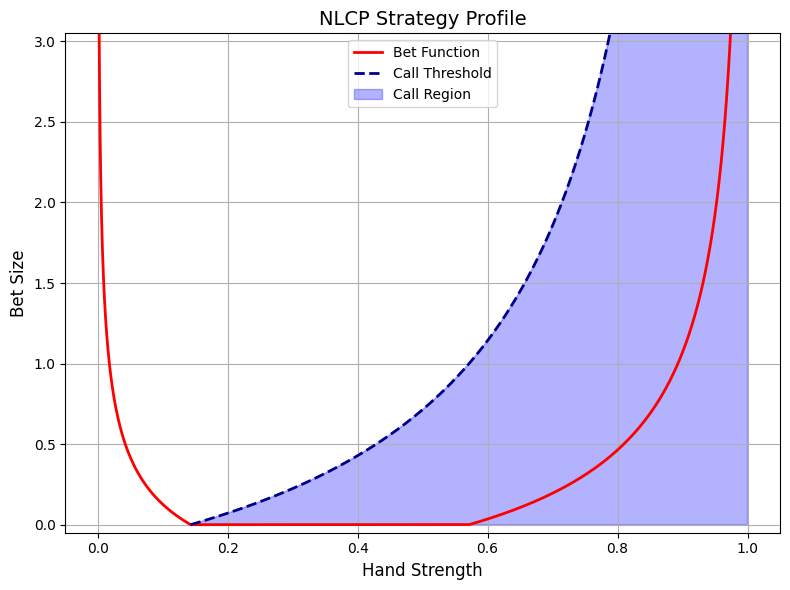

In [50]:
# strategy profile plots
NLCP.generate_strategy_plot(s_lim=3, grid_size=10001)


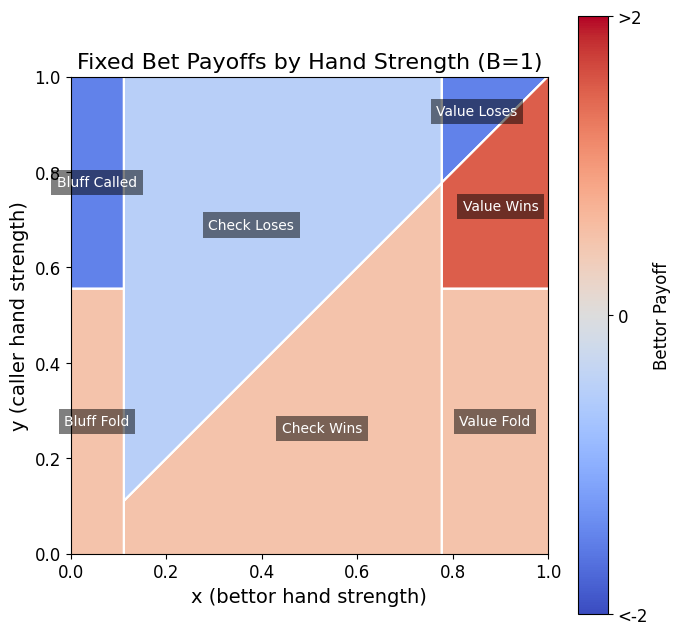

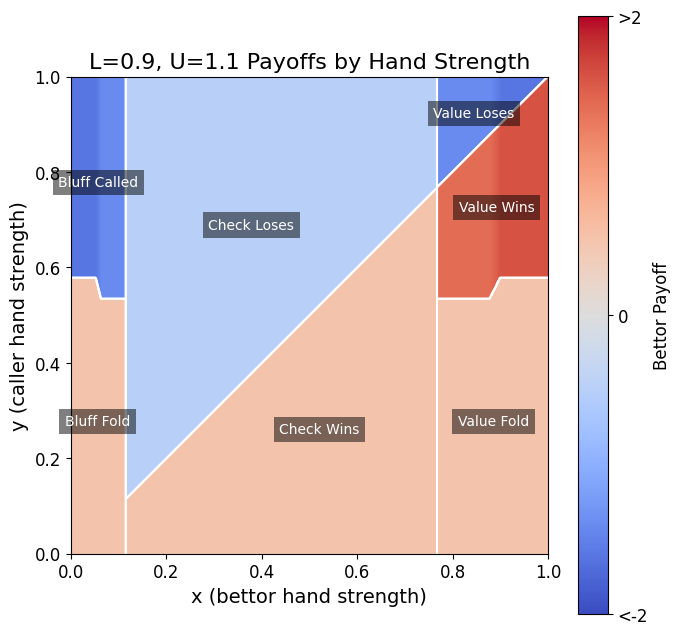

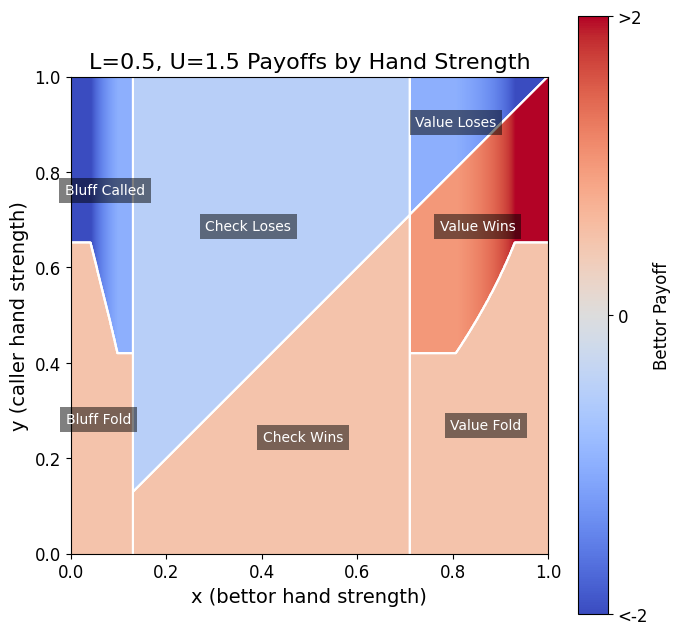

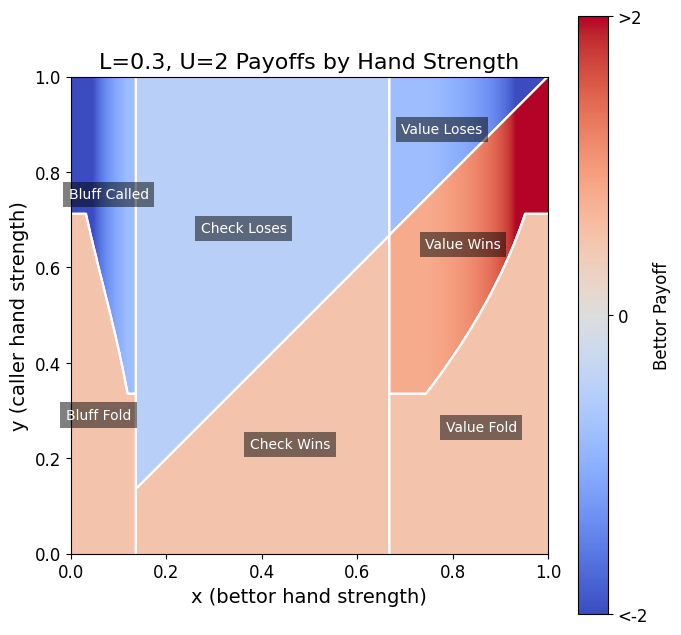

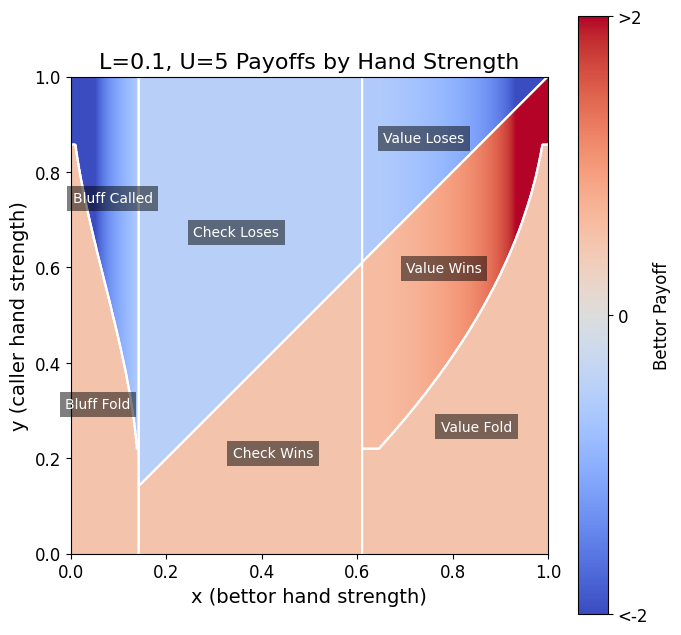

/Users/andrewspears/poker_analysis/game_utils/ContinuousPokerVariants/NLCP.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (7 * x)**(1/3)) - 1
/Users/andrewspears/poker_analysis/game_utils/ContinuousPokerVariants/NLCP.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(3 / (7 * (1 - x))) - 1


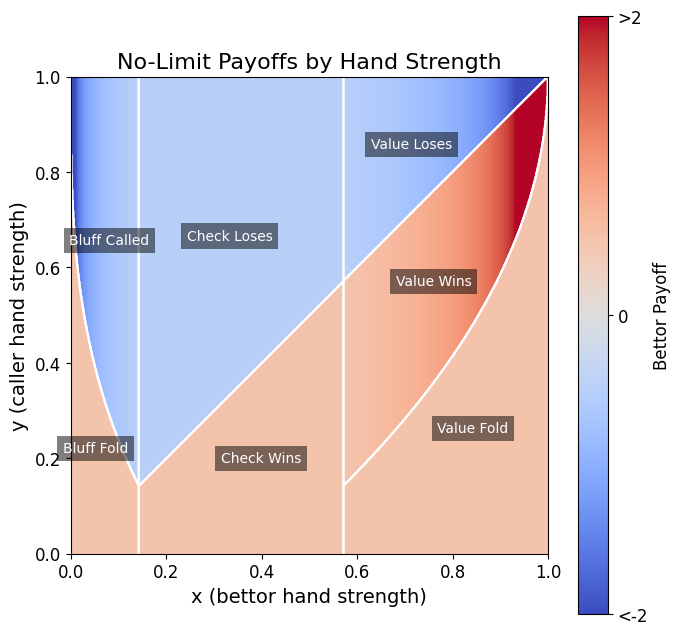

In [60]:
LCP.generate_payoff_plot(L=1, U=1, title="Fixed Bet Payoffs by Hand Strength (B=1)")
LCP.generate_payoff_plot(L=0.9, U=1.1, title="L=0.9, U=1.1 Payoffs by Hand Strength")
LCP.generate_payoff_plot(L=0.5, U=1.5, title="L=0.5, U=1.5 Payoffs by Hand Strength")
LCP.generate_payoff_plot(L=0.3, U=2, title="L=0.3, U=2 Payoffs by Hand Strength")
LCP.generate_payoff_plot(L=0.1, U=5, title="L=0.1, U=5 Payoffs by Hand Strength")
NLCP.generate_payoff_plot(title="No-Limit Payoffs by Hand Strength")